In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pylab as plt
from matplotlib import cm

%matplotlib inline

<b>Finding the relevant data points</b>

In [3]:
'''
Finding relevant data points
'''

year = int(raw_input("Which year do you want to look at, 2016/2017/2018?"))
count = str(raw_input("What's the count, e.g. 2-1?"))
pt = str(raw_input("What type of pitch, either fastball or off-speed?"))
ph = str(raw_input("What's the pitcher's handedness, R or L?"))
bh = str(raw_input("What's the batter's handedness, R or L?"))

#filters out by year
if year == 2016:
    raw = pd.read_csv("2016.csv")
if year == 2017:
    raw = pd.read_csv("2017.csv")
if year == 2018:
    raw = pd.read_csv("2018.csv")

b, s = int(count[0]), int(count[2])

data = raw.loc[:, ('pitch_type', 'balls', 'strikes', 'plate_x', 'plate_z', 'stand', 'p_throws', 'estimated_woba_using_speedangle', 'description', 'events')]

#filters out by ball
data = data.loc[data['balls'] == b]

#filters out by strike
data = data.loc[data['strikes'] == s]

#filters out by pitch type

if pt == 'fastball':
    pitches = ['FA','FT','FF','FC','FS']
if pt == 'off-speed':
    pitches = ['CH', 'CU', 'EP', 'FO', 'KN', 'KC', 'SI', 'SL']
data = data.loc[data['pitch_type'].isin(pitches)]

#filters out by platoon
data = data.loc[data['p_throws'] == ph]
data = data.loc[data['stand'] == bh]

#filters out not hit balls, will need to fix
data = data.loc[data['estimated_woba_using_speedangle'] != 'null']

#filters results where plate_x or plate_z didn't register
data = data.loc[data['plate_x'] != 'null']
data = data.loc[data['plate_z'] != 'null']

#turns database columns into useable lists that are filled with float values (or 'null')

plate_x = data['plate_x'].tolist()
plate_z = data['plate_z'].tolist()
estimated_woba_using_speedangle = data['estimated_woba_using_speedangle'].tolist()

plate_x = [ float(x) for x in plate_x ]
plate_z = [ float(z) for z in plate_z ]
estimated_woba_using_speedangle = [ float(w) for w in estimated_woba_using_speedangle ]

Which year do you want to look at, 2016/2017/2018?2018
What's the count, e.g. 2-1?1-2
What type of pitch, either fastball or off-speed?off-speed
What's the pitcher's handedness, R or L?R
What's the batter's handedness, R or L?R


$k$ <b>nearest neighbors algorithm</b> 

The number of relevant pitches is 3151
How many nearest neighbors do you want to consider?100


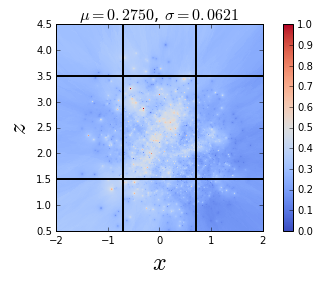

In [7]:
print "The number of relevant pitches is", len(plate_x)
k = int(raw_input("How many nearest neighbors do you want to consider?"))
h = 0.01 #grid spacing (same units as plate_x and plate_z)

#turns location ordered pairs into 2D matrix
X = np.column_stack([plate_x,plate_z])

#target
y = estimated_woba_using_speedangle

#nearest neighbors calculation, points weighted by distance and algorithm chosen by sklearn
neigh = KNeighborsRegressor(k, weights='distance', algorithm='auto')
neigh.fit(X, y) 

# Assign a color to each point in the mesh [x_min, x_max], [y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = neigh.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure()
#batter's box
a,b,c = 0.70833, 1.5, 3.5
plt.axvline(x=-a, linewidth=2, color = 'k')
plt.axvline(x=a, linewidth=2, color = 'k')
plt.axhline(y=b, linewidth=2, color = 'k')
plt.axhline(y=c, linewidth=2, color = 'k')

plt.xlim(-2*a,2*a)
plt.ylim(b-1, c+1)
plt.pcolormesh(xx, yy, Z, vmin = 0.0, vmax = 1.0, cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel(r'$x$',fontsize = 24)
plt.ylabel(r'$z$',fontsize = 24)
plt.title(r'$\mu = %.04f$, $\sigma = %.04f$'%(np.mean(Z),np.std(Z)),fontsize=16)

plt.axes().set_aspect(1)
plt.xticks(np.arange(-2, 3, step=1))
plt.tight_layout()
plt.savefig('15JanMap.jpg')